In [1]:
%cd ~/Dropbox/research/football/code/sfm/
import trainsfm
import sfmnet
import pair_frames_dataset
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
import imageio 

im_channels=1
H=4
W=6
data=torch.ones((8,2*im_channels,H,W))
data[0,0,2,1] = 0
data[0,1,1,1] = 0
data[1,0,2,3] = 0
data[1,1,1,4] = 0
data[2,0,2,3] = 0
data[2,1,2,4] = 0
data[3,0,1,1] = 0
data[3,1,2,2] = 0
data[4,0,1,1] = 0
data[4,1,2,1] = 0
data[5,0,1,2] = 0
data[5,1,2,1] = 0
data[6,0,1,4] = 0
data[6,1,1,3] = 0
data[7,0,2,4] = 0
data[7,1,1,3] = 0
dataset = (data[:,0:1], data[:,1:2])
dl = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=False)
im1, im2 = dl.dataset
len(dl.dataset[0])

/Users/ajaffe/Dropbox/research/football/code/sfm


8

In [2]:
import datetime
def train_model(lr=0.005, hidden_layer_widths=[16], num_epochs=1, flowreg=0., maskreg=0., displreg=0., forwbackwreg=0.):
    model = sfmnet.SfMNet(
        H=H,
        W=W,
        im_channels=im_channels,
        K=1,
        C=4,
        conv_depth=1,
        hidden_layer_widths=hidden_layer_widths,
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)


    time = datetime.datetime.now().strftime('%H:%M:%S')
    trainsfm.train_loop(
        model=model,
        vis_point=None,
        dl=dl,
        optimizer=optimizer,
        num_epochs=num_epochs,
        vis_freq=None,
        tensorboard_dir=f'./tb/08-09/{time}',
        maskreg_coeff=maskreg,
        displreg_coeff=displreg,
        flowreg_coeff=flowreg,
        forwbackwreg_coeff=forwbackwreg,
    )
    return model

def eval_model(model):
    with torch.no_grad():
        output, mask, flow, displacement = model(data)
        loss = torch.mean(torch.abs(output - data[:,1:]), dim=(1,2,3))
        return loss
        

def vis_model(model):
    with torch.no_grad():
        output, mask, flow, displacement = model(data)
        loss = torch.mean(torch.abs(output - data[:,1:]), dim=(1,2,3))
        for l in loss:
            print(("Good " if l < 1/24 else "Bad ") + str(l))

        sfmnet.visualize(model, dataset[0], dataset[1], spacing=1)
# model = train_model(
#     num_epochs=1,
#     lr=0.005,
#     hidden_layer_widths=[32,32],
#     displreg=0.01,
#     maskreg=0.1,
#     forwbackwreg=0.1
# ) 
# vis_model(model)

epoch: 0 recon_loss: 0.16653 loss: 0.27320 total_time: 0.05s epoch_time: 0.05s
epoch: 1 recon_loss: 0.16425 loss: 0.26901 total_time: 0.08s epoch_time: 0.02s
epoch: 2 recon_loss: 0.16454 loss: 0.26250 total_time: 0.09s epoch_time: 0.01s
epoch: 3 recon_loss: 0.16437 loss: 0.25791 total_time: 0.10s epoch_time: 0.01s
epoch: 4 recon_loss: 0.16391 loss: 0.25466 total_time: 0.12s epoch_time: 0.01s
epoch: 5 recon_loss: 0.16378 loss: 0.25052 total_time: 0.13s epoch_time: 0.01s
epoch: 6 recon_loss: 0.16360 loss: 0.24622 total_time: 0.14s epoch_time: 0.01s
epoch: 7 recon_loss: 0.16320 loss: 0.24261 total_time: 0.16s epoch_time: 0.01s
epoch: 8 recon_loss: 0.16273 loss: 0.23906 total_time: 0.17s epoch_time: 0.01s
epoch: 9 recon_loss: 0.16221 loss: 0.23517 total_time: 0.18s epoch_time: 0.01s
epoch: 10 recon_loss: 0.16167 loss: 0.23128 total_time: 0.19s epoch_time: 0.01s
epoch: 11 recon_loss: 0.16113 loss: 0.22759 total_time: 0.21s epoch_time: 0.01s
epoch: 12 recon_loss: 0.16057 loss: 0.22429 total_

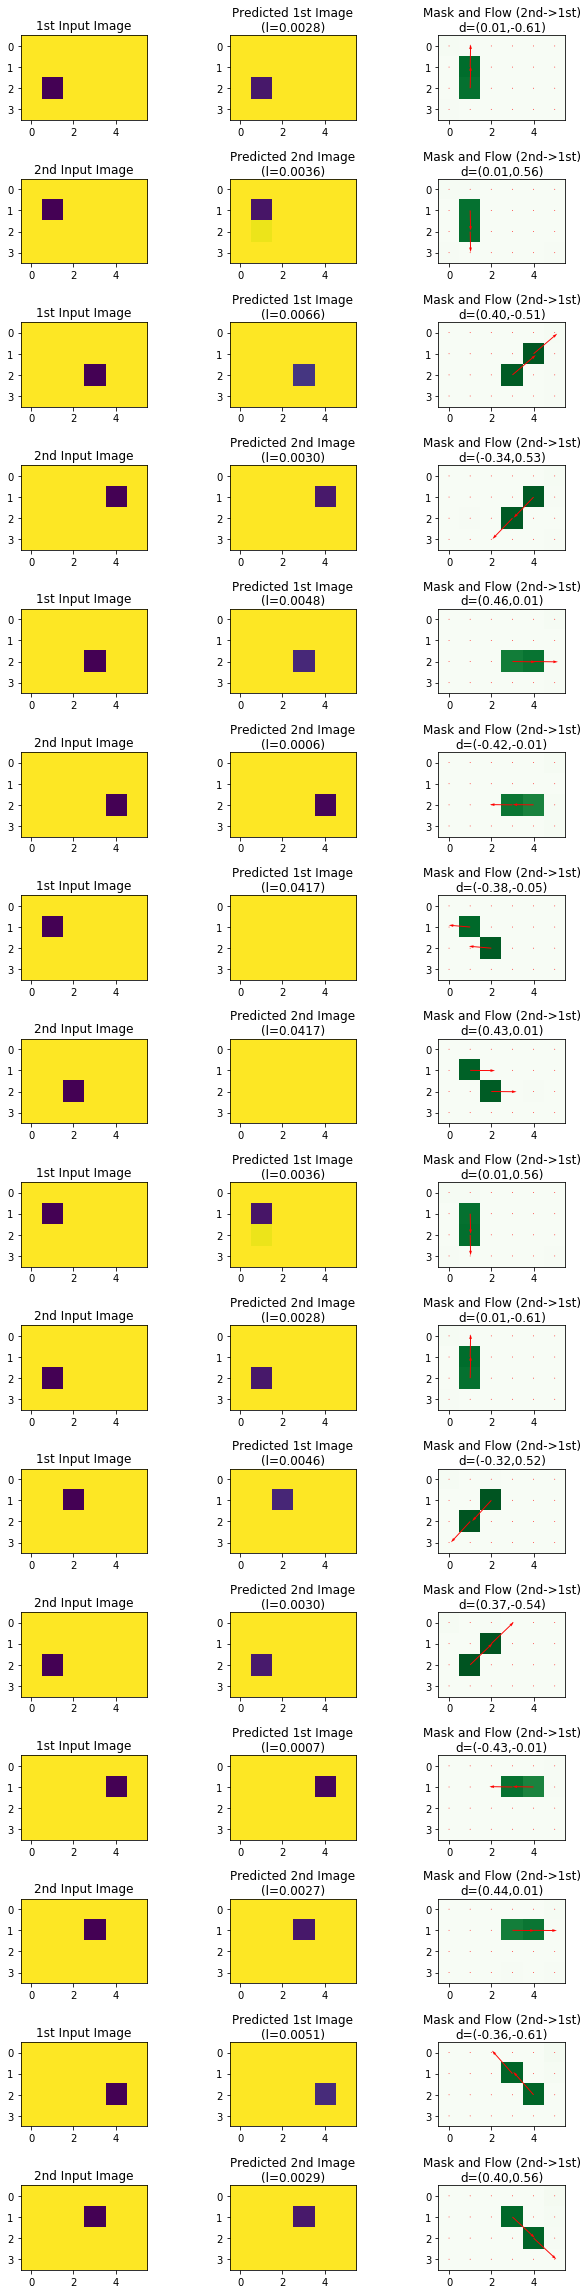

In [3]:
model = train_model(
    num_epochs=300,
    lr=0.005,
    hidden_layer_widths=[32,32],
    displreg=0.01,
    maskreg=0.1,
    forwbackwreg=0.01
) 
vis_model(model)

In [4]:
lrs = [0.005, 0.01, 0.2, 0.0025]
hidden_layer_widths = [[32], [32,32]]
regs=[(0.1, 0.1), (0.01, 0.01), (0.001,0.001)]

hparams = []
for l in lrs:
    for h in hidden_layer_widths:
        for m,d in regs:
            hparams.append({
                'lr': l,
                'hidden_layer_widths': h,
                'maskreg': m,
                'displreg': d
            })
print(hparams[2])
print(hparams[5])
print(hparams[-2])

{'lr': 0.005, 'hidden_layer_widths': [32], 'maskreg': 0.001, 'displreg': 0.001}
{'lr': 0.005, 'hidden_layer_widths': [32, 32], 'maskreg': 0.001, 'displreg': 0.001}
{'lr': 0.0025, 'hidden_layer_widths': [32, 32], 'maskreg': 0.01, 'displreg': 0.01}


In [19]:
num_runs = 2
result = [None] * len(hparams)
for k,hparam in enumerate(hparams):
    ms = [train_model(num_epochs=1, **hparam) for i in range(num_runs)]
    losses = np.array([eval_model(m).numpy() for m in ms])
    good = losses < 1/24
    mediangood = np.median(np.sum(good, axis=1))
    maxgood = np.max(np.sum(good, axis=1))
    mingood = np.max(np.sum(good, axis=1))
    result[k] = {}
    result[k]['loss'] = losses.tolist()
    result[k]['mean_loss'] = np.mean(losses)
    result[k]['good'] = good
    result[k]['mediangood'] = np.median(np.sum(good, axis=1))
for r in result:
    print(r['mediangood'])

epoch: 0 recon_loss: 0.08173 loss: 0.13280 total_time: 0.04s epoch_time: 0.04s
epoch: 0 recon_loss: 0.07970 loss: 0.12936 total_time: 0.04s epoch_time: 0.04s
epoch: 0 recon_loss: 0.07970 loss: 0.08549 total_time: 0.03s epoch_time: 0.03s
epoch: 0 recon_loss: 0.07279 loss: 0.07813 total_time: 0.04s epoch_time: 0.04s
epoch: 0 recon_loss: 0.07711 loss: 0.07762 total_time: 0.04s epoch_time: 0.04s
epoch: 0 recon_loss: 0.07397 loss: 0.07477 total_time: 0.03s epoch_time: 0.03s
epoch: 0 recon_loss: 0.08199 loss: 0.13119 total_time: 0.03s epoch_time: 0.03s
epoch: 0 recon_loss: 0.08221 loss: 0.12035 total_time: 0.03s epoch_time: 0.03s
epoch: 0 recon_loss: 0.08191 loss: 0.08711 total_time: 0.23s epoch_time: 0.23s
epoch: 0 recon_loss: 0.08014 loss: 0.08541 total_time: 0.04s epoch_time: 0.04s
epoch: 0 recon_loss: 0.07255 loss: 0.07327 total_time: 0.05s epoch_time: 0.05s
epoch: 0 recon_loss: 0.08296 loss: 0.08344 total_time: 0.04s epoch_time: 0.04s
epoch: 0 recon_loss: 0.07611 loss: 0.14034 total_tim

In [26]:
import pickle
with open('./data.p', 'wb') as f:
    pickle.dump(result, f)